In [181]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

# Global constants

# crop/patch dimensions for the training samples
WIDTH = 64
HEIGHT = 128

hog = cv.HOGDescriptor(_winSize=(WIDTH, HEIGHT),
                        _blockSize=(16, 16),
                        _blockStride = (8, 8),
                        _cellSize = (8, 8), 
                        _nbins = 9)

num_negative_samples = 10 # number of negative samples per image
train_hog_path = 'train_hog_descs' # the file to which you save the HOG descriptors of every patch

path_train =  '../data/task_data/train/' #CHANGE PATHS DEPENDING ON THE WORKING DIR!
path_test = '../data/task_data/test/'

hog_descriptor_size = 3780 # the feature dimension of a hog descriptor for a single block

colorspace = 1 # 1 for color, 0 for gray
#***********************************************************************************
# draw a bounding box in a given image
# Parameters:
# im: The image on which you want to draw the bounding boxes
# detections: the bounding boxes of the detections (people)
# returns None

In [182]:
# Utility functions

def read_txt_file(filename):
    img_list = []
    with open(filename, "r") as infile: 
        for line in infile:
            line = line.strip()
            img_list.append(line) #value denotes a positive sample - 1 or a negative one - 0
    return img_list

# for each positive image, computes the HOG feature
# for each negative image, 
def extract_img_data(img_list, DIR, positive): #sample_type is either 1 - positive, 0 - negative
    X = []
    Y_labels = []
    if positive:
        for i, img_path in enumerate(img_list):
            try:
                path = os.path.join(DIR, img_path)
                img = cv.imread(path, cv.IMREAD_COLOR)
                # center = (img.shape[0] / 2, img.shape[1] / 2)
                # x = center[1] - WIDTH/2
                # y = center[0] - HEIGHT/2
                # crop_img = img[int(y):int(y+HEIGHT), int(x):int(x+WIDTH), :]
                # X.append(hog.compute(crop_img, (16, 16)))
                
                img = cv.resize(img, (WIDTH, HEIGHT))
                X.append(hog.compute(img))
            except Exception as e: # catch "broken" images where width or height is 0, therefore cannot be resized. 
                print("error loading file: " + img_path + ": "+ str(e))
                # pass
        Y_labels = np.ones(len(X))
        return np.array(X), Y_labels
    else:
        X = []
        for i, img_path in enumerate(img_list):
            try:
                path = os.path.join(DIR, img_path)
                img = cv.imread(path, cv.IMREAD_COLOR)
                patches = extract_patches(img)
                X.extend(patches)
            except Exception as e: # catch "broken" images where width or height is 0, therefore cannot be resized. 
                print(str(e))
        Y_labels = np.zeros(len(X))
        return np.array(X), Y_labels
    
def extract_patches(image, num_patches=10, patch_size=(HEIGHT, WIDTH)):
    image_height, image_width = image.shape[:2]
    patch_height, patch_width = patch_size

    patches = []

    for _ in range(num_patches):
        valid_patch = False

        while not valid_patch:
            # Generate random patch coordinates
            top = np.random.randint(0, image_height - patch_height + 1)
            left = np.random.randint(0, image_width - patch_width + 1)
            bottom = top + patch_height
            right = left + patch_width

            # Check if patch exceeds image boundaries
            if bottom <= image_height and right <= image_width:
                # Extract the patch from each channel
                patch = image[top:bottom, left:right, :]

                patches.append(hog.compute(patch))
                valid_patch = True


    return patches


### Task 1: Extracting HOG Features

In [183]:
# TODO: Create a HOG descriptor object to extract the features from the set of positive and negative samples 

# positive samples: Get a crop of size 64*128 at the center of the image then extract its HOG features
# negative samples: Sample 10 crops from each negative sample at random and then extract their HOG features
# In total you should have  (x+10*y) training samples represented as HOG features(x=number of positive images, y=number of negative images),
# save them and their labels in the path train_hog_path and train_labels in order to load them in section 3 

# Load image names
print(os.getcwd())
filelist_train_pos = path_train + 'filenamesTrainPos.txt'
filelist_train_neg = path_train + 'filenamesTrainNeg.txt'
filelist_test_pos = path_test + 'filenamesTestPos.txt'
filelist_test_neg = path_test + 'filenamesTestNeg.txt'

# Extract HOG features from images

img_pos_list = read_txt_file(filelist_train_pos)
img_neg_list = read_txt_file(filelist_train_neg)
X_train_pos, Y_train_pos = extract_img_data(img_pos_list, path_train+"pos/", positive=True) 
X_train_neg, Y_train_neg = extract_img_data(img_neg_list, path_train+"neg/", positive=False)

img_pos_list = read_txt_file(filelist_test_pos)
img_neg_list = read_txt_file(filelist_test_neg)
X_test_pos, Y_test_pos = extract_img_data(img_pos_list, path_test+"pos/", positive=True) 
X_test_neg, Y_test_neg = extract_img_data(img_neg_list, path_test+"neg/", positive=False)

X_train = np.append(X_train_pos, X_train_neg, axis=0).astype(np.float32)
Y_train = np.append(Y_train_pos, Y_train_neg, axis=0).astype(np.int32)

X_test = np.append(X_test_pos, X_test_neg, axis=0).astype(np.float32)
Y_test = np.append(Y_test_pos, Y_test_neg, axis=0).astype(np.int32)

idx = np.random.permutation(len(X_train)) #shuffling the data
X_train, Y_train = X_train[idx], Y_train[idx]

c:\Users\vinci\Documents\cv2\Advanced-Computer-Vision\SVM\src


In [184]:
# Train the SVMs, using the OpenCV implementation

svms = []

for C in [0.01, 1, 100]:
    svm = cv.ml.SVM_create()
    svm.setType(cv.ml.SVM_C_SVC)
    svm.setKernel(cv.ml.SVM_LINEAR)
    svm.setC(C)
    svm.train(X_train, cv.ml.ROW_SAMPLE, Y_train)
    svms.append((svm, C))

C:\Users\vinci\AppData\Local\Temp\ipykernel_38076\1540537351.py:23: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(FP+TP)


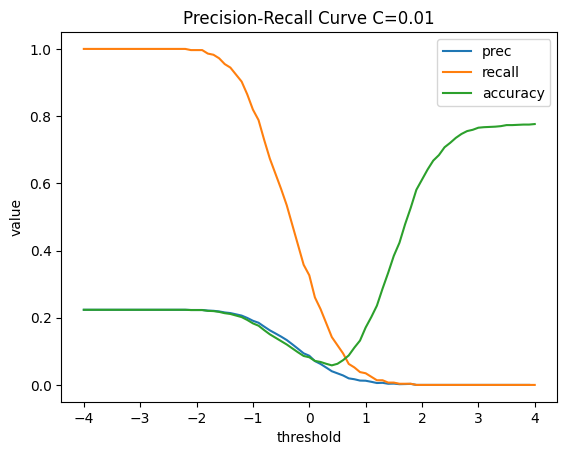

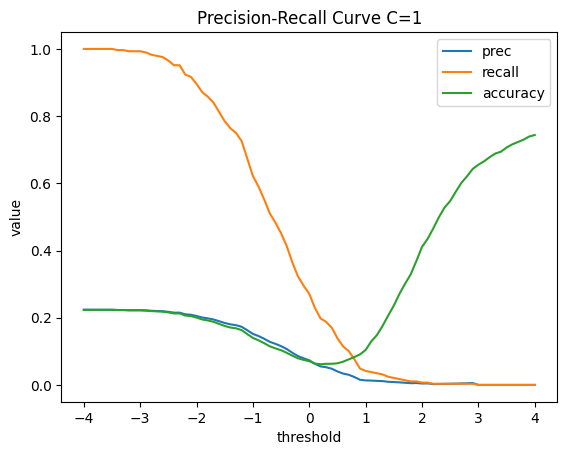

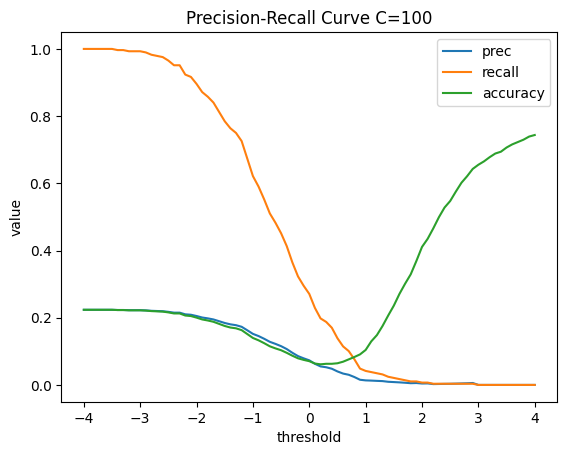

In [185]:
# Predict on test set

for (svm, C) in svms:
    _, Y_pred_dist = svm.predict(X_test, flags=cv.ml.StatModel_RAW_OUTPUT) # retrieve distance to the margin
    Y_pred_dist = np.squeeze(Y_pred_dist) # eliminate unnecessary dimension
    

    with open('confidence_scores' + str(C) + '.txt', 'w') as file:
        for score in Y_pred_dist:
            file.write(str(score) + '\n')

    thresholds = np.arange(-4, 4.1, 0.1)
    precisions = []
    recalls = []
    accuracies = []
    for hit_threshold in thresholds:
        Y_pred = np.where(Y_pred_dist > hit_threshold, 1, 0)

        TP = np.sum(np.where((Y_pred == 1) & (Y_test == 1), 1, 0))
        FP = np.sum(np.where((Y_pred == 1) & (Y_test == 0), 1, 0))
        TN = np.sum(np.where((Y_pred == 0) & (Y_test == 0), 1, 0))
        FN = np.sum(np.where((Y_pred == 0) & (Y_test == 1), 1, 0))
        precision = TP/(FP+TP)
        precisions.append(precision)
        recall = TP/(FN+TP)
        recalls.append(recall)
        accuracy = (TP + TN) / (TP + FP + TN + FN)
        accuracies.append(accuracy)
    
    plt.plot(thresholds, precisions, label='prec')
    plt.plot(thresholds, recalls, label='recall')
    plt.plot(thresholds, accuracies, label='accuracy')
    plt.xlabel('threshold')
    plt.ylabel('value')
    plt.title('Precision-Recall Curve C=' + str(C))
    plt.legend()
    plt.show()
